In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import os
import subprocess
import nibabel as nib
import tensorflow as tf
from skimage import exposure
from math import ceil
import matplotlib.pyplot as plt
import random

class DataLoader:
    def __init__(self, data_path, split_ratio, batch_size=None):
        self.data_path = data_path
        self.split_ratio = split_ratio
        self.all_subjects = None
        self.subjects_lists = []
        self.labels = {'train': 0, 'test': 1, 'validation': 2}
        self.size = [0, 0, 0]
        self.batch_size = batch_size
        self.slices_number = None

    def list_subjects(self):
        subjects = os.listdir(self.data_path)
        subjects = [item for item in subjects if item.startswith('sub')]
        self.all_subjects = subjects

    def get_nifti_path(self, subject, number_of_motion='1'):
        ref_path_stand = f'{self.data_path}/{subject}/anat/{subject}_acq-standard_T1w.nii/'
        select_path_stand = subprocess.run(['ls', ref_path_stand], capture_output=True, text=True).stdout.replace("\n", "")

        ref_path_motion = f'{self.data_path}/{subject}/anat/{subject}_acq-headmotion{number_of_motion}_T1w.nii/'
        select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")

        return [ref_path_stand + select_path_stand, ref_path_motion + select_path_motion]

    def get_paired_volumes(self, path):
        if os.path.exists(path[0]) and os.path.exists(path[1]):
            free_data = nib.load(path[0]).get_fdata()
#             free_data = exposure.rescale_intensity(free_data, out_range=(0.0, 1.0))
            free_data = exposure.rescale_intensity(free_data, out_range=(-1.0, 1.0))

            motion_data = nib.load(path[1]).get_fdata()
#             motion_data = exposure.rescale_intensity(motion_data, out_range=(0.0, 1.0))
            motion_data = exposure.rescale_intensity(motion_data, out_range=(-1.0, 1.0))
            return tf.convert_to_tensor(free_data), tf.convert_to_tensor(motion_data)
        else:
            return None, None

    def split_data(self):
        self.list_subjects()
        if ceil(sum(self.split_ratio)) == 1 and len(self.split_ratio) <= 3:
            self.split_ratio.insert(0, 0)
            cumulative_sum = [sum(self.split_ratio[:i + 1]) for i in range(len(self.split_ratio))]
            number_of_subjects = len(self.all_subjects)

            for i in range(1, len(self.split_ratio)):
                self.subjects_lists.append(
                    self.all_subjects[int(round(cumulative_sum[i - 1] * number_of_subjects)):int(
                        round(cumulative_sum[i] * number_of_subjects))])

                self.size[i - 1] = len(self.subjects_lists[i - 1])  * 2 * 190

                if i - 1 == 0:
                    self.size[i - 1] -= 8  * 2 * 190
        else:
            print("The Summation of ratios is not equal to 1")
       
    def generator(self, mode):
        subjects = self.subjects_lists[self.labels[mode]]

        def data_gen():
            for subject in subjects:
                for i in range(2):
                    pathes = self.get_nifti_path(subject, str(i + 1))
                    free, motion = self.get_paired_volumes(pathes)
                    if motion is not None:
                        self.slices_number = motion.shape[0]

                        for slice_id in range(0, self.slices_number):
                            start_idx = slice_id + 1
                            end_idx = (slice_id + 1) + 1
                            if (end_idx < self.slices_number-1):
                                free_slice = free[start_idx:end_idx]
                                free_slice = tf.transpose(free_slice, perm=[1, 2, 0])
                                
                                motion_slice = motion[start_idx:end_idx]
                                motion_slice = tf.transpose(motion_slice, perm=[1, 2, 0])
                                
                                motion_before_slice = motion[start_idx-1:end_idx-1]
                                motion_before_slice = tf.transpose(motion_before_slice, perm=[1, 2, 0])
                                
                                motion_after_slice = motion[start_idx+1:end_idx+1]
                                motion_after_slice = tf.transpose(motion_after_slice, perm=[1, 2, 0])

                                yield (
                                (motion_before_slice, motion_slice, motion_after_slice),
                                free_slice
                                )

        input_signature = (
            (tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
        )

        dataset = tf.data.Dataset.from_generator(data_gen, output_signature=input_signature)
        dataset = dataset.batch(self.batch_size)

        return dataset

In [15]:
def create_center_rectangle_mask(mask_shape, rect_height, rect_width):
    mask_shape = mask_shape[1:]
    # Create a mask with a central rectangle of zeros
    mask = np.ones(mask_shape, dtype=np.float32)

    # Calculate the position of the top-left corner of the rectangle
    rect_top = (mask_shape[0] - rect_height) // 2
    rect_left = (mask_shape[1] - rect_width) // 2

    # Update the mask with the rectangle at the center
    mask[rect_top:rect_top+rect_height, rect_left:rect_left+rect_width,:] = 0

    # Convert the NumPy array to a TensorFlow tensor
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)

    return mask_tensor

def crop_center_rectangle_mask(tensor, rect_height=50, rect_width=100):
    mask = create_center_rectangle_mask(tensor.shape, rect_height, rect_height)
    return tf.multiply(tensor, mask)

In [16]:
import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import numpy as np

IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING_CHANNELS_FIRST = "channels_first"

# Default IMAGE_ORDERING = channels_last
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

if IMAGE_ORDERING == 'channels_first':
	MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
	MERGE_AXIS = -1

# CBAM --------------------------------------------
# Convolutional Block Attention Module(CBAM) block
def cbam_block(cbam_feature, ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]  # input_feature._keras_shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def UNet(img_input):
	k1 = 32
	k2 = 64
	k3 = 128
	k4 = 256
	# Block 1 in Contracting Path
	conv1 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input)
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation(tf.nn.leaky_relu)(conv1)
	#conv1 = Dropout(0.2)(conv1)
	conv1 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv1)
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation(tf.nn.leaky_relu)(conv1)

	conv1 = cbam_block(conv1)    # Convolutional Block Attention Module(CBAM) block

	o = AveragePooling2D((2, 2), strides=(2, 2))(conv1)

	# Block 2 in Contracting Path
	conv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation(tf.nn.leaky_relu)(conv2)
	conv2 = Dropout(0.2)(conv2)
	conv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv2)
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation(tf.nn.leaky_relu)(conv2)

	conv2 = cbam_block(conv2)    # Convolutional Block Attention Module(CBAM) block

	o = AveragePooling2D((2, 2), strides=(2, 2))(conv2)

	# Block 3 in Contracting Path
	conv3 = Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation(tf.nn.leaky_relu)(conv3)
	#conv3 = Dropout(0.2)(conv3)
	conv3 = Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv3)
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation(tf.nn.leaky_relu)(conv3)

	conv3 = cbam_block(conv3)    # Convolutional Block Attention Module(CBAM) block

	o = AveragePooling2D((2, 2), strides=(2, 2))(conv3)

	 # Transition layer between contracting and expansive paths:
	conv4 = Conv2D(k4, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv4 = BatchNormalization()(conv4)
	conv4 = Activation(tf.nn.leaky_relu)(conv4)
	#conv4 = Dropout(0.2)(conv4)
	conv4 = Conv2D(k4, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv4)
	conv4 = BatchNormalization()(conv4)
	conv4 =Activation(tf.nn.leaky_relu)(conv4)

	conv4 = cbam_block(conv4)    # Convolutional Block Attention Module(CBAM) block


	# Block 1 in Expansive Path
	up1 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(conv4)
	up1 = concatenate([up1, conv3], axis=MERGE_AXIS)
	deconv1 =  Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up1)
	deconv1 = BatchNormalization()(deconv1)
	deconv1 = Activation(tf.nn.leaky_relu)(deconv1)
	#deconv1 = Dropout(0.2)(deconv1)
	deconv1 =  Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv1)
	deconv1 = BatchNormalization()(deconv1)
	deconv1 = Activation(tf.nn.leaky_relu)(deconv1)

	deconv1 = cbam_block(deconv1)    # Convolutional Block Attention Module(CBAM) block

	# Block 2 in Expansive Path
	up2 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(deconv1)
	up2 = concatenate([up2, conv2], axis=MERGE_AXIS)
	deconv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up2)
	deconv2 = BatchNormalization()(deconv2)
	deconv2 = Activation(tf.nn.leaky_relu)(deconv2)
	#deconv2 = Dropout(0.2)(deconv2)
	deconv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv2)
	deconv2 = BatchNormalization()(deconv2)
	deconv2 = Activation(tf.nn.leaky_relu)(deconv2)

	deconv2 = cbam_block(deconv2)    # Convolutional Block Attention Module(CBAM) block

	# Block 3 in Expansive Path
	up3 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(deconv2)
	up3 = concatenate([up3, conv1], axis=MERGE_AXIS)
	deconv3 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up3)
	deconv3 = BatchNormalization()(deconv3)
	deconv3 = Activation(tf.nn.leaky_relu)(deconv3)
	#deconv3 = Dropout(0.2)(deconv3)
	deconv3 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv3)
	deconv3 = BatchNormalization()(deconv3)
	deconv3 = Activation(tf.nn.leaky_relu)(deconv3)

	deconv3 = cbam_block(deconv3)    # Convolutional Block Attention Module(CBAM) block

	output = Conv2D(1, (3, 3), data_format=IMAGE_ORDERING, padding='same')(deconv3)
# 	output = Activation('sigmoid')(output)
	output = Activation('tanh')(output)
	return output

def Correction_Multi_input(input_height, input_width):
	assert input_height % 32 == 0
	assert input_width % 32 == 0

#   UNET
	img_input_1 = Input(shape=(input_height, input_width, 1))
	img_input_2 = Input(shape=(input_height, input_width, 1))
	img_input_3 = Input(shape=(input_height, input_width, 1))
# 	kk = 32
	kk = 64
	conv1 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_1) # dilation_rate=6
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation('relu')(conv1)
	conv2 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_2) # dilation_rate=6
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation('relu')(conv2)
	conv3 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_3) # dilation_rate=6
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation('relu')(conv3)

	input_concat = concatenate([conv1, conv2, conv3], axis=MERGE_AXIS)  #conv4
	# dataset = tf.data.Dataset.from_tensor_slices((img_input_1, img_input_2, img_input_3)

	## Two Stacked Nets:
	pred_1  = UNet(input_concat)
	input_2 = concatenate([input_concat, pred_1], axis=MERGE_AXIS)
	pred_2  = UNet(input_2) #

	model = Model(inputs=[img_input_1,img_input_2,img_input_3], outputs=pred_2)


	return model

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
import math
import pandas as pd
from tensorflow.keras.models import model_from_json

# Constants
TRAIN = 1  # True False
TEST = 0  # True False
NB_EPOCH = 30
LEARNING_RATE = 0.001  # 0.001 (default)
HEIGHT, WIDTH = 256, 256
PREDICTION_PATH = '/kaggle/working/Prediction'
WEIGHTS_PATH = '/kaggle/working/Weights'

print('Reading Data ... ')
data_path = "/kaggle/input/mahmoud-dataset"
split_ratio = [0.7, 0.2, 0.1]
# split_ratio = [0.03, 0.92, 0.03]
batch_size = 14

data_loader = DataLoader(data_path, split_ratio, batch_size)
data_loader.split_data()

train_dataset = data_loader.generator('train')
test_dataset = data_loader.generator('test')
validation_dataset = data_loader.generator('validation')

Reading Data ... 


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def ssim_score(y_true, y_pred):
    score = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return score

def ssim_loss(y_true, y_pred):
    loss_ssim = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return loss_ssim

def l2_loss(y_true, y_pred):
    """
    Computes the L2 loss between the ground truth and predicted tensors.

    Parameters:
        y_true (tf.Tensor): Ground truth tensor.
        y_pred (tf.Tensor): Predicted tensor.

    Returns:
        tf.Tensor: Normalized L2 loss.

    This function calculates the mean squared error (MSE) between the ground truth
    and predicted tensors. It then reduces the MSE along the spatial dimensions,
    typically representing the height and width of the tensors, resulting in a
    tensor of shape (batch_size,), where each element represents the mean MSE
    for a single sample in the batch.

    The loss is then normalized using L2 normalization to ensure that it falls
    within the range of 0 to 1. Finally, the mean of the normalized loss across
    the batch is computed and returned.
    """
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)

    # Reduce on spatial information
    batch_mse = tf.reduce_mean(mse, axis=(1, 2))

    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_mse, axis=-1)
    
    # Compute the mean of the normalized loss across the batch
    normalized_reduced_loss = tf.reduce_mean(batch_mse)

    return normalized_reduced_loss

def spatial_fft_loss(y_true, y_pred):
    """
    Custom loss function for spatial loss with FFT features.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced spatial loss.

    This function defines a custom loss for training neural networks. It applies a Fourier Transform
    to the true and predicted images, extracts the real and imaginary parts of the transformed
    features, and calculates the mean squared error between them. The loss is then normalized and
    reduced to a single scalar value.

    """
    # Apply Fourier Transform to the true and predicted images
    true_fft = tf.signal.fft2d(tf.cast(y_true, dtype=tf.complex64))
    pred_fft = tf.signal.fft2d(tf.cast(y_pred, dtype=tf.complex64))

    # Extract Real & Imaginary parts
    true_fft_real = tf.math.real(true_fft)
    true_fft_imag = tf.math.imag(true_fft)
    pred_fft_real = tf.math.real(pred_fft)
    pred_fft_imag = tf.math.imag(pred_fft)

    # Crop center rectangles for real and imag
    true_fft_real_cropped = crop_center_rectangle_mask(true_fft_real)
    true_fft_imag_cropped = crop_center_rectangle_mask(true_fft_imag)
    pred_fft_real_cropped = crop_center_rectangle_mask(pred_fft_real)
    pred_fft_imag_cropped = crop_center_rectangle_mask(pred_fft_imag)

    # Calculate L2 loss
    mse_real = tf.keras.losses.mean_squared_error(true_fft_real_cropped, pred_fft_real_cropped)
    mse_imag = tf.keras.losses.mean_squared_error(true_fft_imag_cropped, pred_fft_imag_cropped)

    # Total L2 loss
    total_loss = 0.5 * (mse_real + mse_imag)
    
    # Reduce on spatial information
    batch_loss = tf.reduce_mean(total_loss, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def init_vgg16_model(perceptual_layer_name='block3_conv3'):
    """
    Initialize a pre-trained VGG16 model for feature extraction.

    Args:
        perceptual_layer_name: Name of the layer to extract features from.

    Returns:
        Pre-trained VGG16 model with specified layer for feature extraction.

    This function loads a pre-trained VGG16 model with ImageNet weights and removes the top
    classification layers. It then extracts the specified layer for feature extraction and
    freezes the model's layers to prevent further training.

    """
    # Load pre-trained VGG16 model without the top classification layers
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

    # Extract the specified layer from the VGG16 model
    perceptual_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer(perceptual_layer_name).output)

    # Freeze the layers in the perceptual model so they are not trained further
    for layer in perceptual_model.layers:
        layer.trainable = False
        
    print("VGG16 Model Initialized")
    return perceptual_model

# Initialize VGG16 model for feature extraction
perceptual_model = init_vgg16_model()

def perceptual_fft_loss(y_true, y_pred):
    """
    Custom loss function for perceptual loss with FFT features.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced perceptual loss.

    This function defines a custom loss for training neural networks. It extracts features from
    true and predicted images using a pre-trained VGG16 model, applies a Fourier Transform to these
    features, and calculates the mean squared error between the real and imaginary parts of the
    transformed features. The loss is then normalized and reduced to a single scalar value.

    """
    # Convert single-channel images to RGB
    y_true_rgb = tf.repeat(y_true, 3, axis=-1)
    y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)

    # Preprocess images for VGG16
    y_true_processed = tf.keras.applications.vgg16.preprocess_input(y_true_rgb)
    y_pred_processed = tf.keras.applications.vgg16.preprocess_input(y_pred_rgb)

    # Extract features from specified layer for true and predicted images
    features_true = perceptual_model(y_true_processed)
    features_pred = perceptual_model(y_pred_processed)

    # Apply Fourier Transform to the true and predicted images
    true_fft = tf.signal.fft2d(tf.cast(features_true, dtype=tf.complex64))
    pred_fft = tf.signal.fft2d(tf.cast(features_pred, dtype=tf.complex64))

    # Extract Real & Imaginary parts
    true_fft_real = tf.math.real(true_fft)
    true_fft_imag = tf.math.imag(true_fft)
    pred_fft_real = tf.math.real(pred_fft)
    pred_fft_imag = tf.math.imag(pred_fft)

    # Crop center rectangles for real and imag
    true_fft_real_cropped = crop_center_rectangle_mask(true_fft_real)
    true_fft_imag_cropped = crop_center_rectangle_mask(true_fft_imag)
    pred_fft_real_cropped = crop_center_rectangle_mask(pred_fft_real)
    pred_fft_imag_cropped = crop_center_rectangle_mask(pred_fft_imag)

    # Calculate L2 loss
    mse_real = tf.keras.losses.mean_squared_error(true_fft_real_cropped, pred_fft_real_cropped)
    mse_imag = tf.keras.losses.mean_squared_error(true_fft_imag_cropped, pred_fft_imag_cropped)

    # Total L2 loss
    total_loss = 0.5 * (mse_real + mse_imag)
    
    # Reduce on spatial information
    batch_loss = tf.reduce_mean(total_loss, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

def perceptual_loss(y_true, y_pred):
    """
    Custom loss function for perceptual loss.

    Args:
        y_true: Ground truth image(s).
        y_pred: Predicted image(s).

    Returns:
        Normalized reduced perceptual loss.

    This function defines a custom loss for training neural networks. It converts single-channel
    images to RGB, preprocesses them for VGG16, and extracts features from a specified layer
    using a pre-trained VGG16 model. It then calculates the mean squared error between the features
    of the true and predicted images. The loss is normalized and reduced to a single scalar value.

    """
    # Convert single-channel images to RGB
    y_true_rgb = tf.repeat(y_true, 3, axis=-1)
    y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)

    # Preprocess images for VGG16
    y_true_processed = tf.keras.applications.vgg16.preprocess_input(y_true_rgb)
    y_pred_processed = tf.keras.applications.vgg16.preprocess_input(y_pred_rgb)

    # Extract features from specified layer for true and predicted images
    features_true = perceptual_model(y_true_processed)
    features_pred = perceptual_model(y_pred_processed)

    # Calculate L2 loss
    mse = tf.keras.losses.mean_squared_error(features_true, features_pred)

    # Reduce on spatial information
    batch_loss = tf.reduce_mean(mse, axis=(1, 2))
    
    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_loss, axis=-1)

    normalized_reduced_loss = tf.reduce_mean(normalized_loss)

    return normalized_reduced_loss

def psnr(y_true, y_pred):
    return tf.reduce_mean(-tf.image.psnr(y_true, y_pred, max_val=2.0))  # Adjust max_val for data normalized between -1 and 1

VGG16 Model Initialized


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_metrics(dataset_path):
    """
    Plot training metrics from the CSV file.

    Args:
    dataset_path (str): Path to the directory containing the CSV file.
    """
    # Read the CSV file
#     data = pd.read_csv(f"{dataset_path}/Weights_Loss_Acc.csv")
    data = pd.read_csv('/kaggle/input/learning-rate-curve/Weights_Loss_Acc.csv')

    # Extract data for plotting
    epochs = data['epoch']+1
    loss = data['loss']
    val_loss = data['val_loss']
    mse = data['mse']
    val_mse = data['val_mse']
    psnr = data['psnr']
    val_psnr = data['val_psnr']
    ssim_score = data['ssim_score']
    val_ssim_score = data['val_ssim_score']

    # Plotting the metrics
    plt.figure(figsize=(12, 6))

    # MSE
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mse, label='Training MSE')
    plt.plot(epochs, val_mse, label='Validation MSE')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.title('Training and Validation MSE', fontsize=16)
    plt.legend()
    plt.xticks(epochs[::4].astype(int), fontsize=12)
    plt.yticks(fontsize=12)

    # SSIM
    plt.subplot(1, 2, 2)
    plt.plot(epochs, ssim_score, label='Training SSIM')
    plt.plot(epochs, val_ssim_score, label='Validation SSIM')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('SSIM Score', fontsize=14)
    plt.title('Training and Validation SSIM Score', fontsize=16)
    plt.legend()
    plt.xticks(epochs[::4].astype(int), fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics_plot.png')
    plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_metrics(dataset_path):
    """
    Plot training metrics from the CSV file.

    Args:
    dataset_path (str): Path to the directory containing the CSV file.
    """
    # Read the CSV file
    data = pd.read_csv(f"{dataset_path}/Weights_Loss_Acc.csv")
#     data = pd.read_csv('/kaggle/input/learning-rate-curve/Weights_Loss_Acc.csv')

    # Extract data for plotting
    epochs = data['epoch']+1
    loss = data['loss']
    val_loss = data['val_loss']
    mse = data['mse']
    val_mse = data['val_mse']
    psnr = data['psnr']
    val_psnr = data['val_psnr']
    ssim_score = data['ssim_score']
    val_ssim_score = data['val_ssim_score']

    # Plotting the metrics
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.xticks(epochs[::5].astype(int))

    # MSE
    plt.subplot(2, 2, 2)
    plt.plot(epochs, mse, label='Training MSE')
    plt.plot(epochs, val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.xticks(epochs[::5].astype(int))

    # PSNR
    plt.subplot(2, 2, 3)
    plt.plot(epochs, psnr, label='Training PSNR')
    plt.plot(epochs, val_psnr, label='Validation PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Training and Validation PSNR')
    plt.legend()
    plt.xticks(epochs[::5].astype(int))

    # SSIM
    plt.subplot(2, 2, 4)
    plt.plot(epochs, ssim_score, label='Training SSIM')
    plt.plot(epochs, val_ssim_score, label='Validation SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM Score')
    plt.title('Training and Validation SSIM Score')
    plt.legend()
    plt.xticks(epochs[::5].astype(int))

    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics_plot.png')
    plt.show()

In [31]:
from tensorflow.keras.models import load_model
from scipy import ndimage
import os
import tensorflow.keras.backend as K

def load_and_sort_paths(dataset_path):
    """
    Load and sort paths from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: Sorted list of paths.
    """
    pathes = os.listdir(dataset_path)
    pathes.sort()
    pathes = pathes[1:]
    return pathes

def load_and_filter_volumes(dataset_path):
    """
    Load and filter volume names from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: List of filtered volume names.
    """
    volumes = os.listdir(dataset_path)
    volumes = [item for item in volumes if item.startswith('sub')]
    return volumes

def sample_reshape(sample):
    sample = sample.reshape(1,sample.shape[0],sample.shape[1])
    return sample

def plot_samples(volumes, model_path, number_of_samples, norm=True):
    """
    Plot samples consisting of motion, free, and predicted images.

    Args:
    volumes (list): List of volume names.
    model_path (str): Path to the trained model.
    number_of_samples (int): Number of samples to plot.
    norm (bool, optional): Normalize the image intensities. Defaults to True.
    """
    angle = 90
    subs = np.random.randint(104, 134, number_of_samples)
    samples = np.random.randint(27, 165, number_of_samples)

    for i in range(number_of_samples):
        path = '/kaggle/input/mahmoud-dataset'
        ref_path_free = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-standard_T1w.nii/'
        select_path_free = subprocess.run(['ls', ref_path_free], capture_output=True, text=True).stdout.replace("\n", "")
        ref_path_motion = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-headmotion2_T1w.nii/'
        select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")
        if not os.path.exists(ref_path_motion + select_path_motion):
            print(f"Ref path motion doesn't exist: {ref_path_motion}")
            continue
        motion_vol = nib.load(ref_path_motion+select_path_motion).get_fdata()
        free_vol = nib.load(ref_path_free+select_path_free).get_fdata()
        free_vol = free_vol.astype(np.float32)
        motion_vol = motion_vol.astype(np.float32)
        
        model = load_model(model_path, custom_objects={'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
        
        if norm:
            motion_vol = exposure.rescale_intensity(motion_vol, out_range=(0.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol, out_range=(0.0, 1.0))
        else:
            motion_vol = exposure.rescale_intensity(motion_vol, out_range=(-1.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol, out_range=(-1.0, 1.0))
        
        pred_image = model.predict([sample_reshape(motion_vol[samples[i]-1]), sample_reshape(motion_vol[samples[i]]), sample_reshape(motion_vol[samples[i]+1])])

        # Plot Images
        plt.figure(figsize=(8, 30),facecolor='black')
#         fig = plt.figure()

        # Plot Motion Image
        rotated_motion = ndimage.rotate(motion_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 1)
        plt.imshow(rotated_motion, cmap='gray')
        plt.title('Motion Image', color='white')
        plt.axis('off')

        # Plot Free Image
        rotated_free = ndimage.rotate(free_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 2)
        plt.imshow(rotated_free, cmap='gray')
        plt.title('Free Image', color='white')
        plt.axis('off')

        # Plot Model Image
        rotated_pred = ndimage.rotate(pred_image[0], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 3)
        plt.imshow(rotated_pred, cmap='gray')
        plt.title('Model Image', color='white')
        plt.axis('off')
        
#         rotated_pred = ndimage.rotate(pred_image[0], angle)
#         diff_img = (rotated_free-rotated_pred.reshape(256,256))
#         plt.subplot(number_of_samples, 4, i * 4 + 4)
#         plt.imshow(diff_img, cmap='gray')
#         plt.title('Diff Image', color='white')
#         plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'sample_{i + 1}.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

    # Display the plot
    

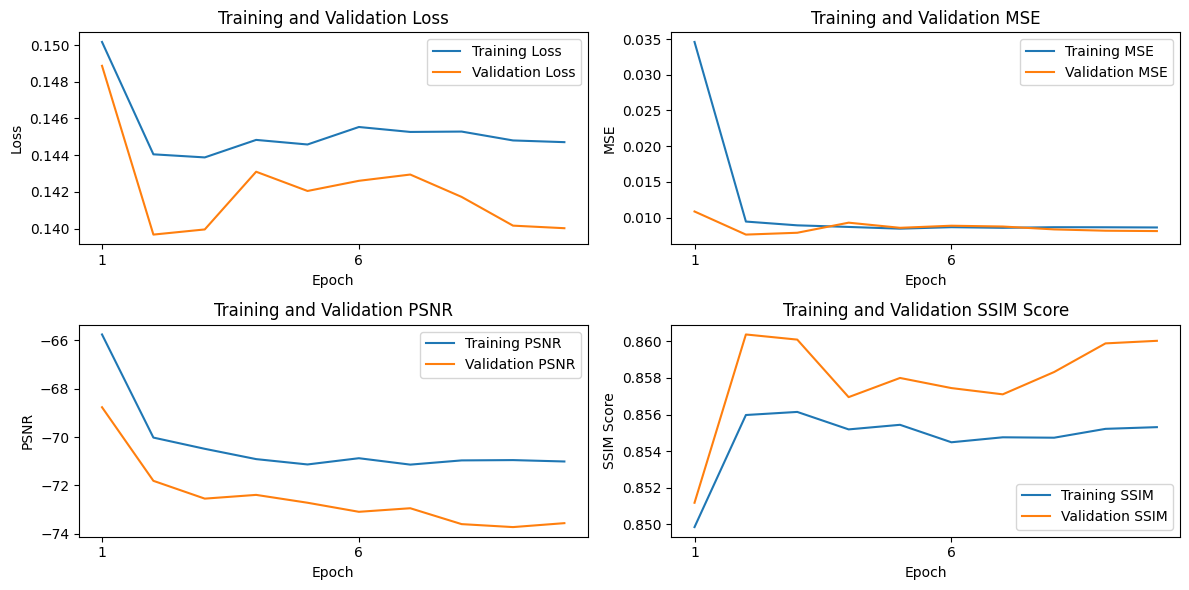

In [32]:
# Plot training metrics
dataset_path = r"/kaggle/input/ssim-fft-l2"
plot_training_metrics(dataset_path)

Epoch: stacked_model_more_deep_01_val_loss_0.1489.h5
1/1 [==============================] - 3s 3s/step


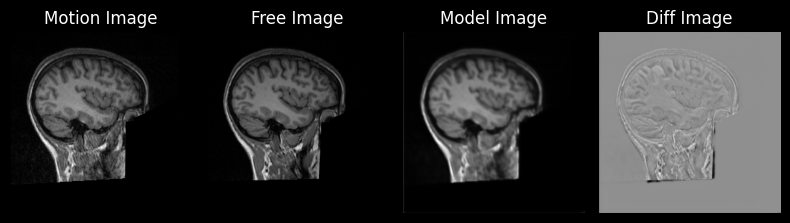

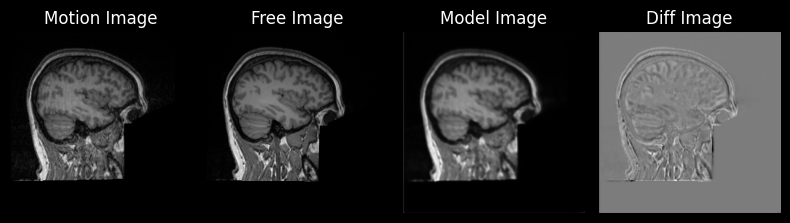

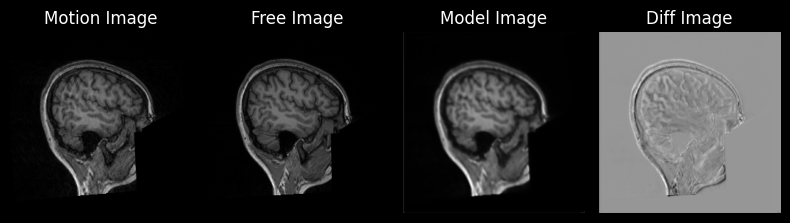

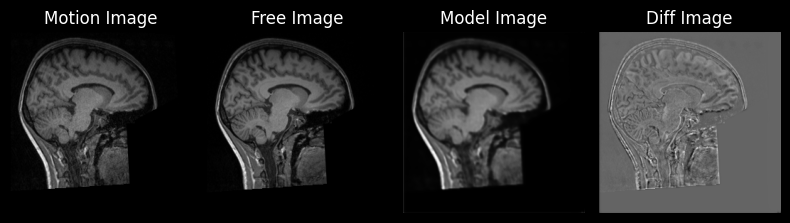

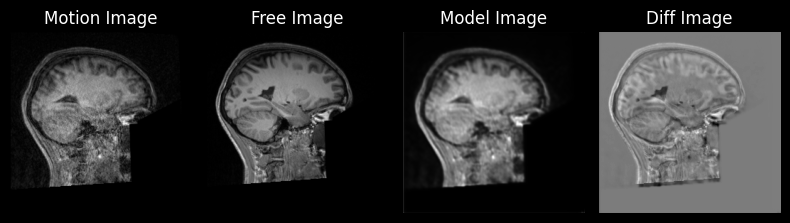

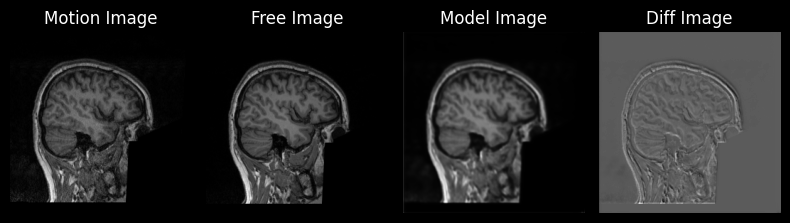

Epoch: stacked_model_more_deep_03_val_loss_0.1400.h5
1/1 [==============================] - 3s 3s/step


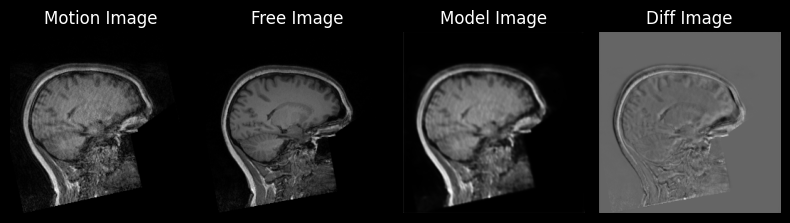

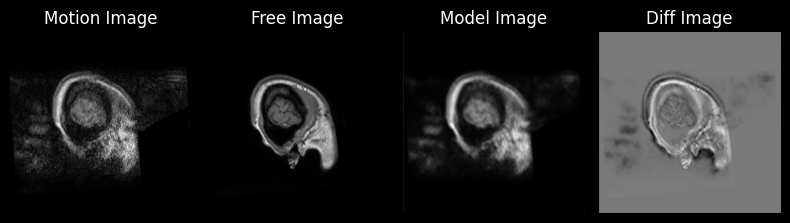

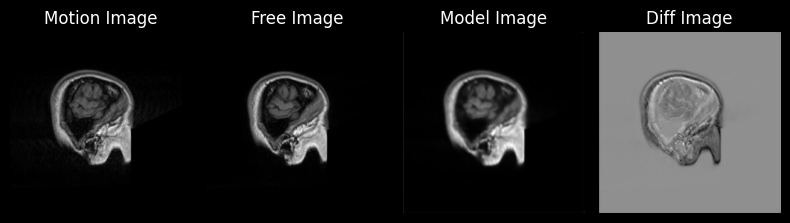

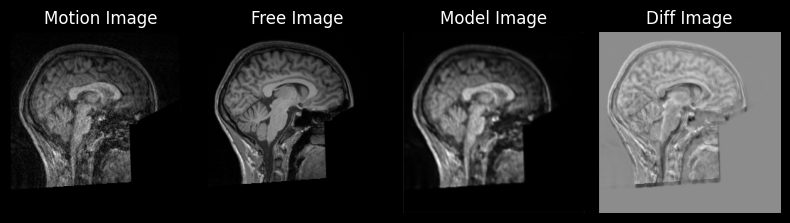

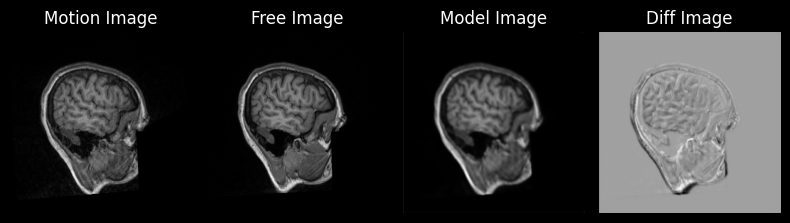

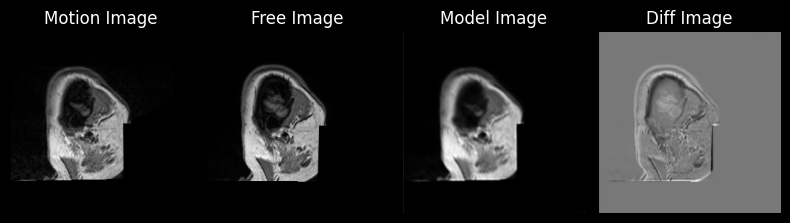

Epoch: stacked_model_more_deep_04_val_loss_0.1431.h5
1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

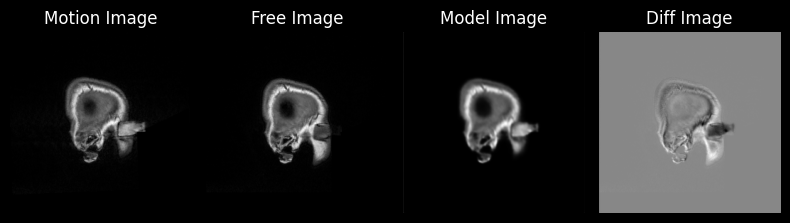

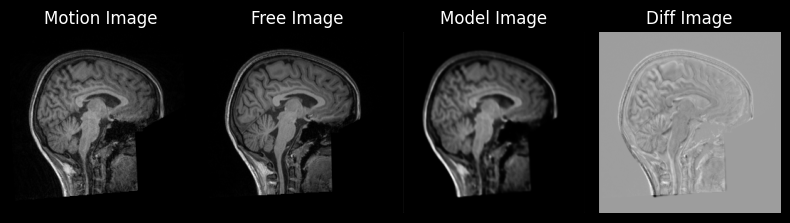

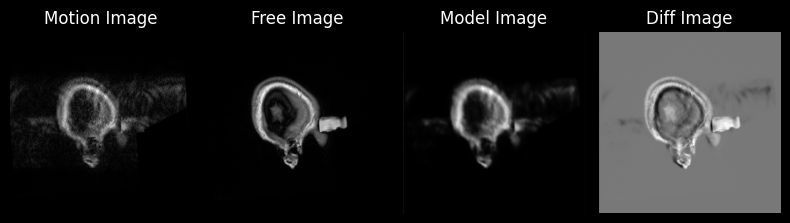

In [23]:
# Define Total Loss
def total_loss(y_true, y_pred):
    return (1/3)*(ssim_loss(y_true, y_pred)+l2_loss(y_true, y_pred)+spatial_fft_loss(y_true, y_pred))

# Load and sort paths
pathes = load_and_sort_paths(dataset_path)

# Load and filter volumes
volumes = load_and_filter_volumes('/kaggle/input/mahmoud-dataset')

# Iterate over paths and plot samples
for path in pathes:
    print(f"Epoch: {path}")
    plot_samples(volumes, f"{dataset_path}/{path}", 6, norm=False)

In [ ]:
model41 = load_model('/kaggle/input/ssim-fft-l2/stacked_model_more_deep_10_val_loss_0.1400.h5', custom_objects={'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
print(model41.evaluate(test_dataset))
# model60 = load_model('/kaggle/input/stackedunet-20epoch-ssim-l2/stacked_model_ssim_l2_60_val_loss_0.0735.h5', custom_objects={'total_loss': total_loss, 'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
# print(model60.evaluate(test_dataset))